In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append(os.path.realpath('..'))

In [3]:
import numpy as np
import plotly.express as ex
import plotly.graph_objects as go
import pandas as pd
import cache_magic

from math import sqrt
from numpy import exp

from tracking.motion import constant_velocity_models, constant_acceleration_models, singer_acceleration_models
from tracking.target import ConstantAccelerationTarget, ConstantVelocityTarget, SinusTarget, SingerTarget
from tracking.kalman import kalman_pv
from tracking.simulation import monte_carlo, rmse, execute, state_residuals
from tracking.evaluation import create_track, create_truth_track, compare_tracks, Track, compare_tracks_mahalanobis, mahalanobis_distance

from tracking.util import to_df, as_png

%cache magic is now registered in ipython


In [9]:
def calculate_mahalanobis_for_sim_run(group):
    mean, median = [], []
    for result in group:
        est = create_track(result)
        tru = create_truth_track(result)
        mah = mahalanobis_distance(est, tru)
        
        mean.append(mah.mean())
        median.append(np.median(mah))
    
    return pd.DataFrame(dict(mean=mean, median=median,
                             noise_intensity=group[0].motion_model.noise_intensity,
                             motion_class=group[0].motion.split('_')[0]))

## Constant-Velocity Target

In [19]:
target = ConstantVelocityTarget(30)

z_sigma = [.87, 8.7, 87]
n       = 600
seeds   = np.arange(200)

In [20]:
motion  = constant_velocity_models(.1, .5, 1, 5, 10)
%cache cv_cv_res  = monte_carlo([target], motion, z_sigma, n=n, seeds=seeds)

motion  = constant_acceleration_models(.1, .5, 1, 5, 10)
%cache cv_ca_res  = monte_carlo([target], motion, z_sigma, n=n, seeds=seeds)

motion  = singer_acceleration_models((1, .1), (1, .5), (1, 1), (1, 5), (1, 10))
%cache cv_sn_res  = monte_carlo([target], motion, z_sigma, n=n, seeds=seeds)

creating new value for variable 'cv_cv_res'
creating new value for variable 'cv_ca_res'
creating new value for variable 'cv_sn_res'


In [22]:
data = pd.concat([df.group_by(exclude='seed').apply_df(calculate_mahalanobis_for_sim_run) for df in (cv_cv_res, cv_ca_res, cv_sn_res)])
data

,mean,median,noise_intensity,motion_class,target,motion,z_sigma,R
0,1.539095,1.268832,0.1,cv,cv,cv_0.1,0.87,0.7569
1,1.607104,1.350071,0.1,cv,cv,cv_0.1,0.87,0.7569
2,1.553811,1.302341,0.1,cv,cv,cv_0.1,0.87,0.7569
3,1.523782,1.293156,0.1,cv,cv,cv_0.1,0.87,0.7569
4,1.548828,1.296776,0.1,cv,cv,cv_0.1,0.87,0.7569
...,...,...,...,...,...,...,...,...
2995,1.291091,1.220928,10.0,singer,cv,singer_1_10,87.00,7569.0000
2996,1.271639,1.233677,10.0,singer,cv,singer_1_10,87.00,7569.0000
2997,1.286996,1.236725,10.0,singer,cv,singer_1_10,87.00,7569.0000
2998,1.326123,1.272318,10.0,singer,cv,singer_1_10,87.00,7569.0000


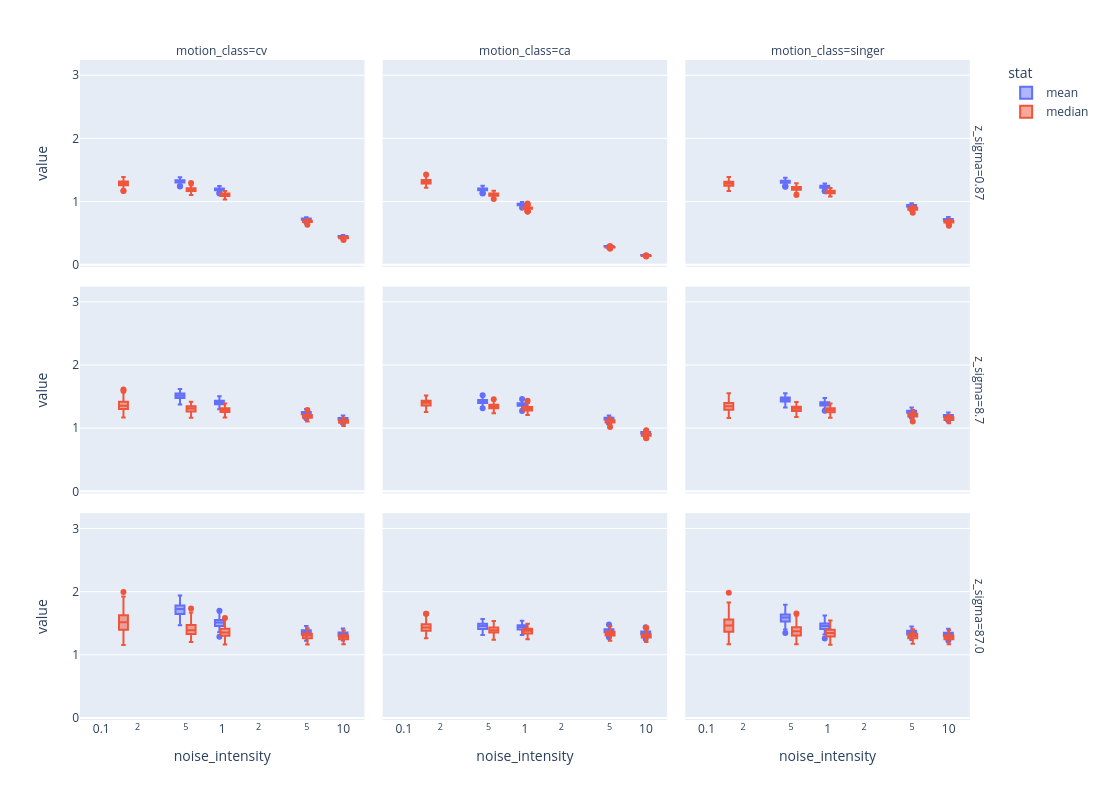

In [25]:
melted = data.melt(['motion', 'z_sigma', 'R', 'target', 'motion_class', 'noise_intensity'], ['mean', 'median'], 'stat')

fig = ex.box(melted, y='value', x='noise_intensity', color='stat', facet_col='motion_class', facet_row='z_sigma', log_x=True)
fig.update_layout(height=800)

## Constant-Acceleration Target

In [26]:
target = ConstantAccelerationTarget(10)

z_sigma = [.87, 8.7, 87]
n       = 600
seeds   = np.arange(100)

In [27]:
motion = constant_velocity_models(.1, .5, 1, 5, 10)
%cache ca_cv_res  = monte_carlo([target], motion, z_sigma, n=n, seeds=seeds)

motion = constant_acceleration_models(.1, .5, 1, 5, 10)
%cache ca_ca_res  = monte_carlo([target], motion, z_sigma, n=n, seeds=seeds)

motion = singer_acceleration_models((1, .1), (1, .5), (1, 1), (1, 5), (1, 10))
%cache ca_sn_res  = monte_carlo([target], motion, z_sigma, n=n, seeds=seeds)

creating new value for variable 'ca_cv_res'
creating new value for variable 'ca_ca_res'
creating new value for variable 'ca_sn_res'


In [28]:
data = pd.concat([df.group_by(exclude='seed').apply_df(calculate_mahalanobis_for_sim_run) for df in (ca_cv_res, ca_ca_res, ca_sn_res)])
data

,mean,median,noise_intensity,motion_class,target,motion,z_sigma,R
0,160.536617,162.147121,0.1,cv,ca_10,cv_0.1,0.87,0.7569
1,160.395525,162.044555,0.1,cv,ca_10,cv_0.1,0.87,0.7569
2,160.445905,162.061341,0.1,cv,ca_10,cv_0.1,0.87,0.7569
3,160.385581,161.981941,0.1,cv,ca_10,cv_0.1,0.87,0.7569
4,160.326645,161.947192,0.1,cv,ca_10,cv_0.1,0.87,0.7569
...,...,...,...,...,...,...,...,...
1495,1.668921,1.632785,10.0,singer,ca_10,singer_1_10,87.00,7569.0000
1496,1.693078,1.664291,10.0,singer,ca_10,singer_1_10,87.00,7569.0000
1497,1.712957,1.677062,10.0,singer,ca_10,singer_1_10,87.00,7569.0000
1498,1.597695,1.542973,10.0,singer,ca_10,singer_1_10,87.00,7569.0000


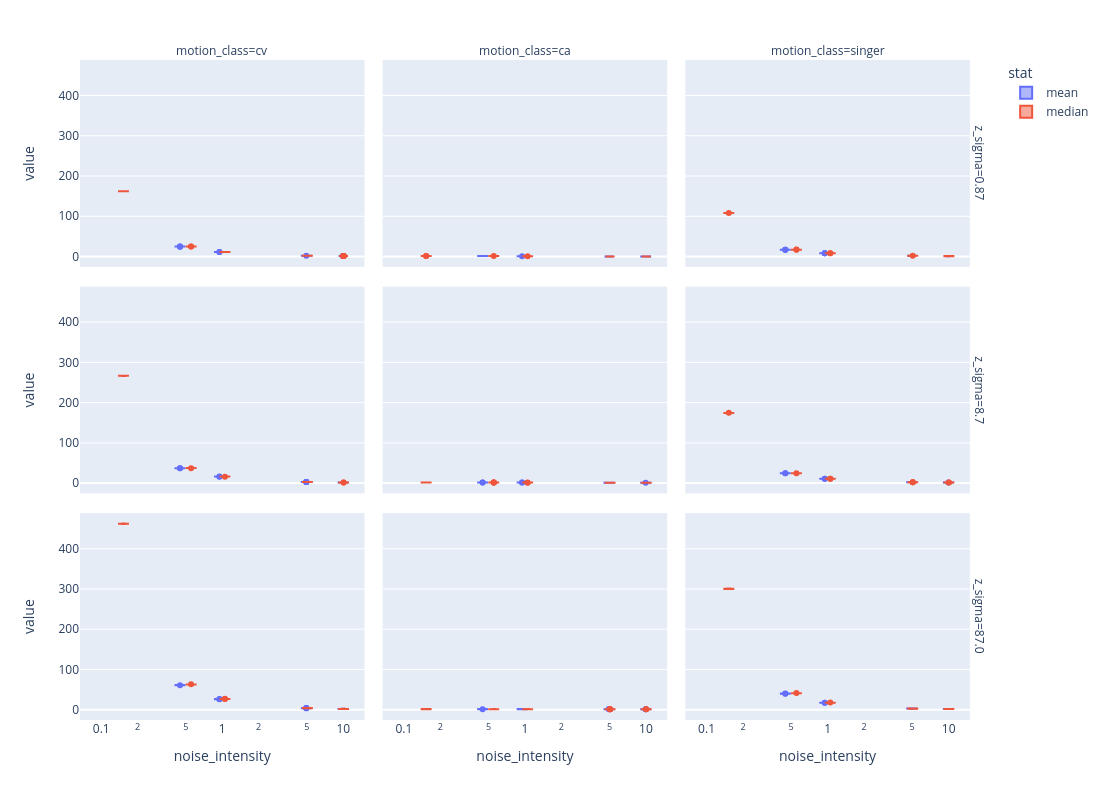

In [29]:
melted = data.melt(['motion', 'z_sigma', 'R', 'target', 'motion_class', 'noise_intensity'], ['mean', 'median'], 'stat')

fig = ex.box(melted, y='value', x='noise_intensity', color='stat', facet_col='motion_class', facet_row='z_sigma', log_x=True)
fig.update_layout(height=800)

## Singer Target

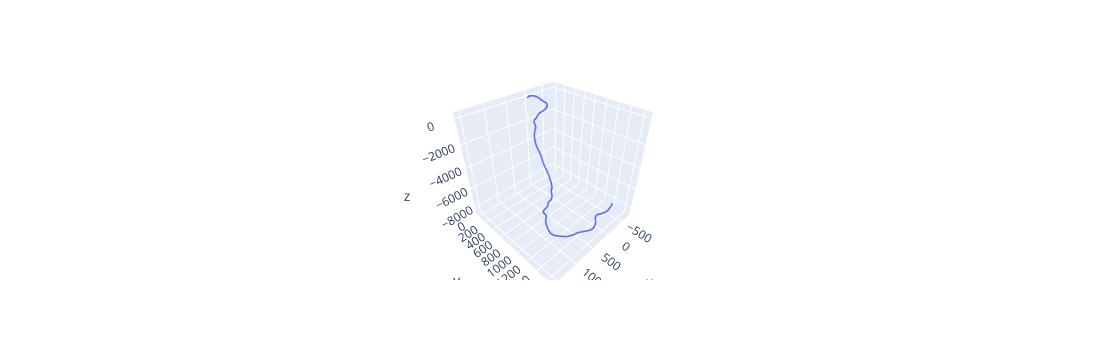

In [30]:
target = SingerTarget(1, 1, seed=0)

fig = ex.scatter_3d(target.true_states_df(), x='x', y='y', z='z')
fig.update_traces(marker_size = 1)
fig

In [31]:
target  = SingerTarget(1, 1)

z_sigma = [.87, 8.7, 87]
n       = 600
seeds   = np.arange(100)

In [32]:
motion = constant_velocity_models(.1, .5, 1, 5, 10)
%cache sn_cv_res  = monte_carlo([target], motion, z_sigma, n=n, seeds=seeds)

motion = constant_acceleration_models(.1, .5, 1, 5, 10)
%cache sn_ca_res  = monte_carlo([target], motion, z_sigma, n=n, seeds=seeds)

motion = singer_acceleration_models((1, .1), (1, .5), (1, 1), (1, 5), (1, 10))
%cache sn_sn_res  = monte_carlo([target], motion, z_sigma, n=n, seeds=seeds)

creating new value for variable 'sn_cv_res'
creating new value for variable 'sn_ca_res'
creating new value for variable 'sn_sn_res'


In [33]:
data = pd.concat([df.group_by(exclude='seed').apply_df(calculate_mahalanobis_for_sim_run) for df in (sn_cv_res, sn_ca_res, sn_sn_res)])
data

,mean,median,noise_intensity,motion_class,target,motion,z_sigma,R
0,12.464962,11.767570,0.1,cv,singer_1_1,cv_0.1,0.87,0.7569
1,12.751818,12.038131,0.1,cv,singer_1_1,cv_0.1,0.87,0.7569
2,11.885105,11.473196,0.1,cv,singer_1_1,cv_0.1,0.87,0.7569
3,12.982711,12.822456,0.1,cv,singer_1_1,cv_0.1,0.87,0.7569
4,12.307695,12.000351,0.1,cv,singer_1_1,cv_0.1,0.87,0.7569
...,...,...,...,...,...,...,...,...
1495,1.302979,1.235229,10.0,singer,singer_1_1,singer_1_10,87.00,7569.0000
1496,1.307766,1.254997,10.0,singer,singer_1_1,singer_1_10,87.00,7569.0000
1497,1.368133,1.350504,10.0,singer,singer_1_1,singer_1_10,87.00,7569.0000
1498,1.323253,1.262966,10.0,singer,singer_1_1,singer_1_10,87.00,7569.0000


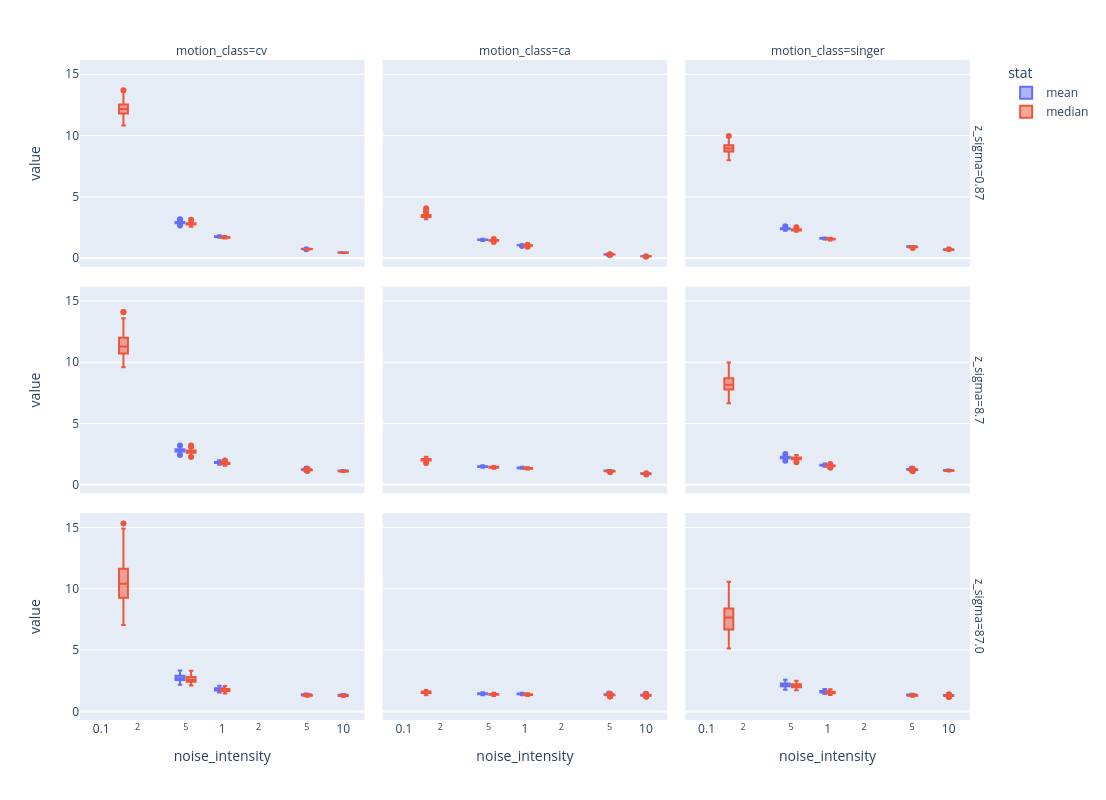

In [34]:
melted = data.melt(['motion', 'z_sigma', 'R', 'target', 'motion_class', 'noise_intensity'], ['mean', 'median'], 'stat')

fig = ex.box(melted, y='value', x='noise_intensity', color='stat', facet_col='motion_class', facet_row='z_sigma', log_x=True)
fig.update_layout(height=800)

In [44]:
df.groupby('motion').apply(lambda x: np.mean(x['mean']))

motion
ca_1          1.065887
cv_1          1.767221
singer_1_1    1.617236
dtype: float64

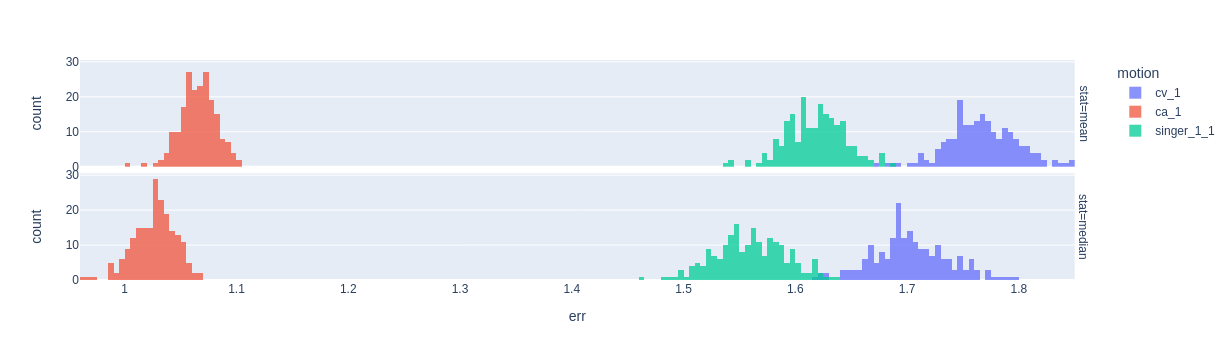

In [45]:
fig = ex.histogram(df.melt(['motion'], ['mean', 'median'], 'stat', 'err'), x='err', color='motion', facet_row='stat', nbins=200)
fig.update_traces(opacity=0.75)
fig.update_layout(barmode='overlay')
fig

In [ ]:
compare_tracks_mahalanobis(a, c, t, "split")

## Singer Target, fast-moving

Here, we set the $tau$ parameter of Singer target to $0.1$ to indicate a target whose dynamics greatly exceed sampling rate of the sensor. We could alternatively keep $tau$ at $1$ and set sampling rate to $10$.

In [35]:
target  = SingerTarget(.1, 1)

z_sigma = [.87, 8.7, 87]
n       = 600
seeds   = np.arange(100)

In [36]:
motion = constant_velocity_models(.1, .5, 1, 5, 10)
%cache sn01_cv_res  = monte_carlo([target], motion, z_sigma, n=n, seeds=seeds)

motion = constant_acceleration_models(.1, .5, 1, 5, 10)
%cache sn01_ca_res  = monte_carlo([target], motion, z_sigma, n=n, seeds=seeds)

motion = singer_acceleration_models((1, .1), (1, .5), (1, 1), (1, 5), (1, 10))
%cache sn01_sn_res  = monte_carlo([target], motion, z_sigma, n=n, seeds=seeds)

creating new value for variable 'sn01_cv_res'
creating new value for variable 'sn01_ca_res'
creating new value for variable 'sn01_sn_res'


In [37]:
data = pd.concat([df.group_by(exclude='seed').apply_df(calculate_mahalanobis_for_sim_run) for df in (sn01_cv_res, sn01_ca_res, sn01_sn_res)])
data

,mean,median,noise_intensity,motion_class,target,motion,z_sigma,R
0,8.822599,8.360982,0.1,cv,singer_0.1_1,cv_0.1,0.87,0.7569
1,9.021915,8.657210,0.1,cv,singer_0.1_1,cv_0.1,0.87,0.7569
2,8.443503,8.241234,0.1,cv,singer_0.1_1,cv_0.1,0.87,0.7569
3,9.157680,9.224948,0.1,cv,singer_0.1_1,cv_0.1,0.87,0.7569
4,8.701415,8.565114,0.1,cv,singer_0.1_1,cv_0.1,0.87,0.7569
...,...,...,...,...,...,...,...,...
1495,1.300560,1.233474,10.0,singer,singer_0.1_1,singer_1_10,87.00,7569.0000
1496,1.307548,1.251584,10.0,singer,singer_0.1_1,singer_1_10,87.00,7569.0000
1497,1.366809,1.350297,10.0,singer,singer_0.1_1,singer_1_10,87.00,7569.0000
1498,1.322136,1.255914,10.0,singer,singer_0.1_1,singer_1_10,87.00,7569.0000


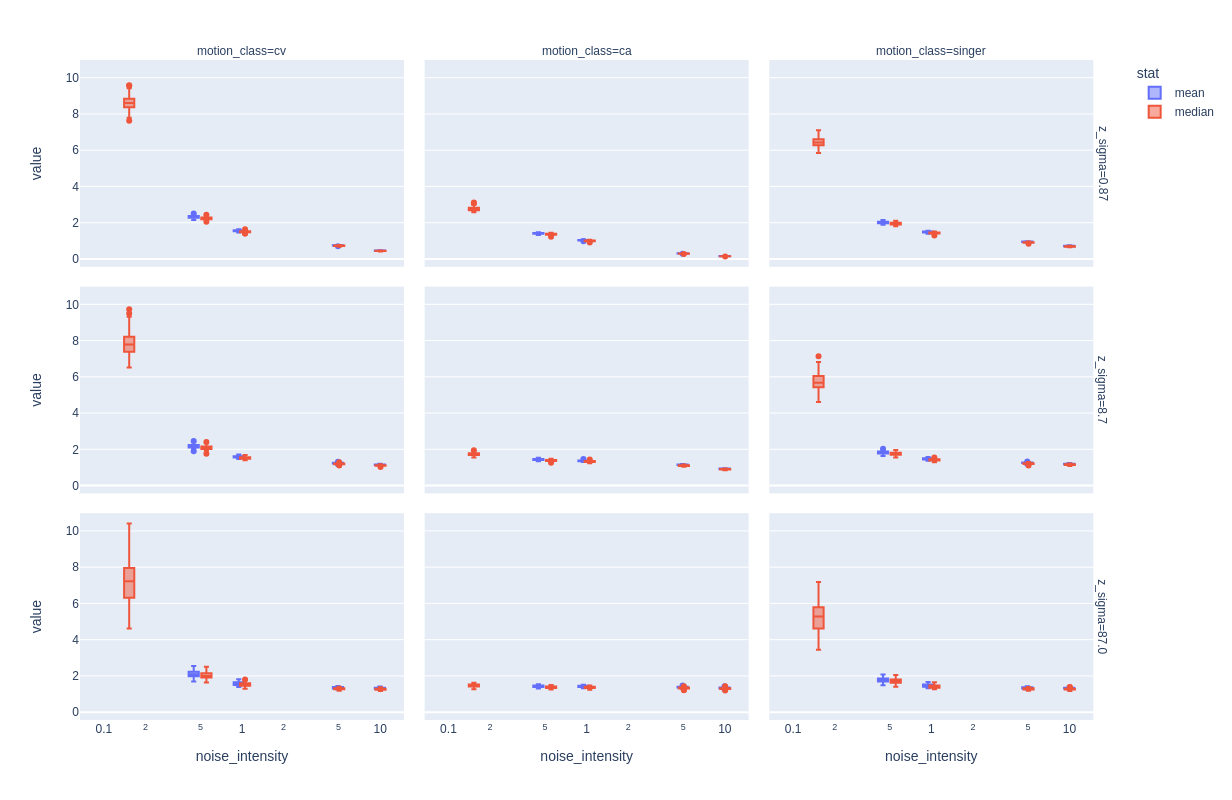

In [38]:
melted = data.melt(['motion', 'z_sigma', 'R', 'target', 'motion_class', 'noise_intensity'], ['mean', 'median'], 'stat')

fig = ex.box(melted, y='value', x='noise_intensity', color='stat', facet_col='motion_class', facet_row='z_sigma', log_x=True)
fig.update_layout(height=800)